# Input Processing

In [28]:
from IPython.display import display
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import posixpath
import wfdb
import pycwt as wavelet
import data
from PIL import Image
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [2]:
dataset_name = 'afdb'
dataset = data.AFECGDataset(dataset_name, '../data/files/', transform=False)


In [3]:
record, label = dataset[0]
print('P-signal #1: ', record)
print('Has AF: ', 'Yes' if label == 1 else 'No')

P-signal #1:  tensor([[-0.2750, -0.2950, -0.3100,  ...,  0.2150,  0.4400,  0.6250],
        [ 0.6800,  0.3350, -0.4400,  ..., -0.0750, -0.1250, -0.1500],
        [-0.1950, -0.2200, -0.2450,  ..., -0.2700, -0.2600, -0.2600],
        ...,
        [-0.1100, -0.1500, -0.1500,  ...,  0.1550,  0.1800,  0.1950],
        [ 0.2000,  0.2500,  0.2400,  ..., -0.8700, -0.6200, -0.4450],
        [-0.3650, -0.3200, -0.2650,  ..., -1.4750, -1.3000, -0.9800]],
       dtype=torch.float64)
Has AF:  Yes


## Wavelet transform

Wavelet decomposition:

Time:  (375,)
Frequencies:  (20,)
Power:  (20, 375)


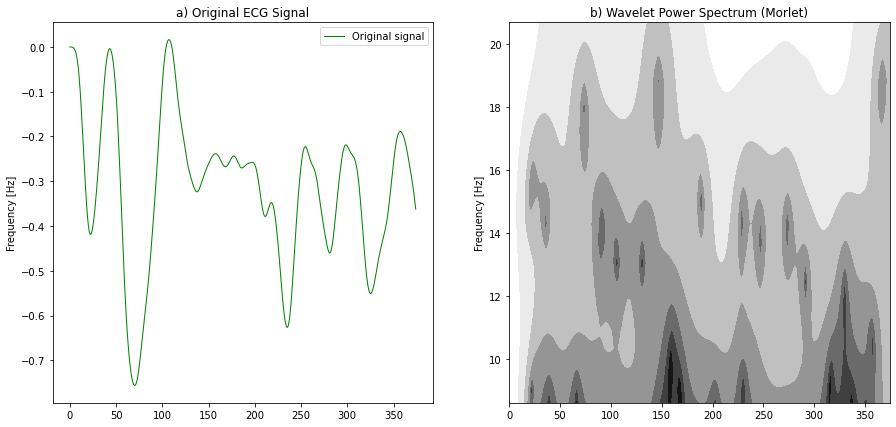

In [25]:
import dsp

signal = record[0]
t, frequencies, power, new_signal = dsp.wavelet_decompose_power_spectrum(signal, resample=20)
dsp.plot_wavelet_decomposition(t, new_signal, frequencies, power, wavelet_name='Morlet')

In [27]:
s = time.time()

to_wavelet = data.WaveletTransform(wavelet.Morlet(6), resample=20)
t = to_wavelet(signal)

e = time.time()

display(t.shape)
print('WaveletTransform took {:2} ms'.format((e - s) * 1000))

torch.Size([20, 375])

WaveletTransform took 3.924846649169922 ms


## ECG Processing

In [ ]:
# Use the GQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

# Load the WFDB record and the physical samples
record = wfdb.rdrecord(data_path + record_name, sampfrom=0, sampto=sampto, channels=[0])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record 100")
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on record" + record_name)
    

In [ ]:
# Use the XQRS detection algorithm and compare results to reference annotations
import wfdb
from wfdb import processing
sig, fields = wfdb.rdsamp(data_path + record_name, channels=[0], sampto=sampto)
ann_ref = wfdb.rdann(data_path + record_name, 'atr', sampto=sampto)

# Run QRS detection on signal
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()
# Alternatively, use the gateway function to get the QRS indices directly
# qrs_inds = processing.xqrs_detect(sig=sig[:,0], fs=fields['fs'])

# Compare detected QRS complexes to reference annotation.
# Note, first sample in 100.atr is not a QRS.
comparitor = processing.compare_annotations(ref_sample=ann_ref.sample[1:],
                                            test_sample=xqrs.qrs_inds,
                                            window_width=int(0.1 * fields['fs']),
                                            signal=sig[:,0])

# Print and plot the results
comparitor.print_summary()
comparitor.plot(title='xqrs detected QRS vs reference annotations')